# CNN intro

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.datasets.cifar10 import  load_data

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()
print(f"{X_train.shape=}, {X_test.shape=}")

y_train, y_test = y_train.ravel(), y_test.ravel()
print(f"{y_train.shape=}, {y_test.shape=}")

X_train.shape=(50000, 32, 32, 3), X_test.shape=(10000, 32, 32, 3)
y_train.shape=(50000,), y_test.shape=(10000,)


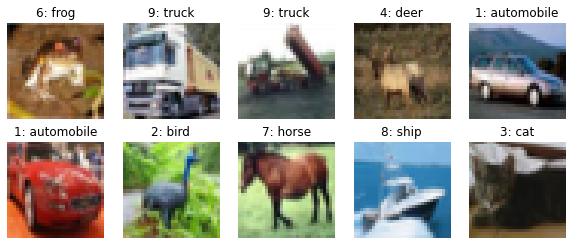

In [3]:
labels = ["airplane",
          "automobile",
          "bird",
          "cat",
          "deer",
          "dog",
          "frog",
          "horse",
          "ship",
          "truck"]

fig, axes = plt.subplots(2, 5, figsize = (10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i])
    ax.set_title(f"{y_train[i]}: {labels[y_train[i]]}")
    ax.axis("off")

In [4]:
scaled_X_train = X_train.astype("float32") / 255
scaled_X_test = X_test.astype("float32") / 255

# CNN MODEL

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [6]:
def CNN_model(learning_rate = .001, drop_rate = .5, kernels = [32, 64]):
    adam = Adam(learning_rate = learning_rate)
    
    model = Sequential(name = "CNN_model")
    
    # the convolutional layers
    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_normal", input_shape = X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPool2D(pool_size = (2, 2), strides = 2))
    
    # MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu",  kernel_initializer = "he_normal"))
    model.add(Dense(len(labels), activation = "softmax")) # output layer, 1 node per label
    
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])
    
    return model

model = CNN_model()
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0 

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
early_stopper = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

model.fit(scaled_X_train, 
          y_train, 
          epochs = 100,
          callbacks = [early_stopper],
          validation_split = 1/5
          )

Epoch 1/100
1250/1250 [==============================] - 9s 3ms/step - loss: 1.5545 - acc: 0.4372 - val_loss: 1.2466 - val_acc: 0.5583
Epoch 2/100
1250/1250 [==============================] - 3s 3ms/step - loss: 1.2273 - acc: 0.5658 - val_loss: 1.0970 - val_acc: 0.6136
Epoch 3/100
1250/1250 [==============================] - 3s 3ms/step - loss: 1.0866 - acc: 0.6153 - val_loss: 1.0379 - val_acc: 0.6448
Epoch 4/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.9876 - acc: 0.6531 - val_loss: 0.9676 - val_acc: 0.6656
Epoch 5/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.8991 - acc: 0.6819 - val_loss: 0.9049 - val_acc: 0.6872
Epoch 6/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.8343 - acc: 0.7085 - val_loss: 0.8826 - val_acc: 0.6920
Epoch 7/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.7742 - acc: 0.7266 - val_loss: 0.8782 - val_acc: 0.6965
Epoch 8/100
1250/1250 [==============================] 

In [14]:
def plot_metrics(metrics):
     _, ax = plt.subplots(1, 2, figsize = (12, 4))
     metrics[["loss", "val_loss"]].plot(ax = ax[0], grid = True)
     metrics[["acc", "val_acc"]].plot(ax = ax[1], grid = True)

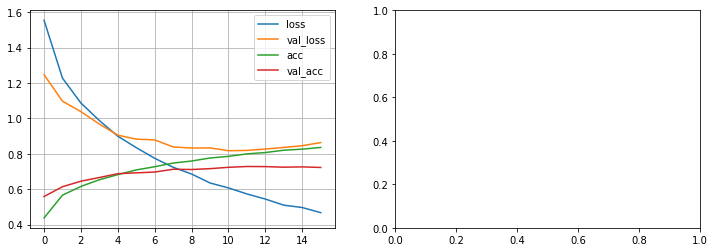

In [13]:
metrics = pd.DataFrame(model.history.history)

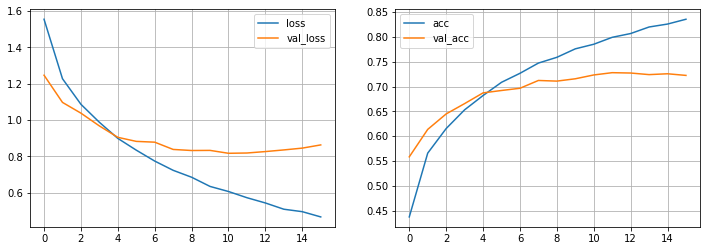

In [16]:
plot_metrics(metrics)

## Hyperparameter tuning

In [17]:
def evaluate_model(**kwargs):
    model = CNN_model(**kwargs)
    model.fit(
        scaled_X_train,
        y_train,
        validation_split = 1/5,
        epochs = 6
    )
    
    metrics = pd.DataFrame(model.history.history)
    val_acc = metrics["val_acc"].iloc[-1]
    return val_acc

In [18]:
dropout_acc = {}

for drop_rate in np.arange(.1, .6, .1):
    drop_rate = np.round(drop_rate, 1)
    dropout_acc[drop_rate] = evaluate_model(drop_rate = drop_rate)

Epoch 1/6
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3393 - acc: 0.5230 - val_loss: 1.1230 - val_acc: 0.6048
Epoch 2/6
1250/1250 [==============================] - 3s 3ms/step - loss: 0.9939 - acc: 0.6515 - val_loss: 0.9751 - val_acc: 0.6628
Epoch 3/6
1250/1250 [==============================] - 3s 3ms/step - loss: 0.8304 - acc: 0.7114 - val_loss: 0.8967 - val_acc: 0.6904
Epoch 4/6
1250/1250 [==============================] - 3s 3ms/step - loss: 0.7063 - acc: 0.7533 - val_loss: 0.8508 - val_acc: 0.7101
Epoch 5/6
1250/1250 [==============================] - 3s 3ms/step - loss: 0.5930 - acc: 0.7928 - val_loss: 0.9047 - val_acc: 0.6969
Epoch 6/6
1250/1250 [==============================] - 3s 3ms/step - loss: 0.4910 - acc: 0.8264 - val_loss: 0.9272 - val_acc: 0.6965
Epoch 1/6
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4522 - acc: 0.4775 - val_loss: 1.1936 - val_acc: 0.5809
Epoch 2/6
1250/1250 [==============================] - 3s 3ms/step - 

<AxesSubplot:xlabel='Dropouts', ylabel='Validation  acc'>

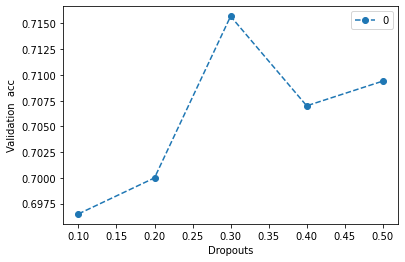

In [21]:
pd.DataFrame(dropout_acc.values(), index = dropout_acc.keys()).plot(xlabel = "Dropouts", ylabel = "Validation  acc", style = "--o")

## When finished
- train on all training data (train and validation) with the tuned parameters
- evaluate on testing data

In [23]:
model_final = CNN_model(drop_rate = 0.3)
model_final.fit(scaled_X_train, y_train, epochs = 6)

Epoch 1/6
1563/1563 [==============================] - 4s 3ms/step - loss: 1.3623 - acc: 0.5121
Epoch 2/6
1563/1563 [==============================] - 4s 3ms/step - loss: 1.0326 - acc: 0.6369
Epoch 3/6
1563/1563 [==============================] - 4s 3ms/step - loss: 0.8877 - acc: 0.6878
Epoch 4/6
1563/1563 [==============================] - 4s 3ms/step - loss: 0.7733 - acc: 0.7304
Epoch 5/6
1563/1563 [==============================] - 4s 3ms/step - loss: 0.6884 - acc: 0.7595
Epoch 6/6
1563/1563 [==============================] - 4s 3ms/step - loss: 0.6088 - acc: 0.7868


              precision    recall  f1-score   support

           0       0.82      0.69      0.75      1000
           1       0.84      0.85      0.84      1000
           2       0.61      0.62      0.62      1000
           3       0.50      0.58      0.54      1000
           4       0.65      0.70      0.67      1000
           5       0.64      0.60      0.62      1000
           6       0.86      0.73      0.79      1000
           7       0.77      0.80      0.79      1000
           8       0.83      0.81      0.82      1000
           9       0.76      0.86      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000



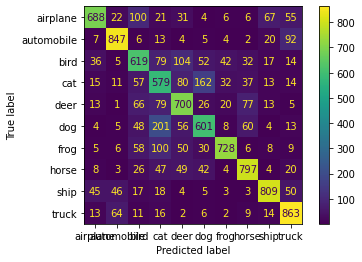

In [25]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

y_pred = model_final.predict(scaled_X_test)
y_pred = np.argmax(y_pred, axis = 1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()